In [1]:
from framework.simulation import FaradayThinSource,FaradayThickSource
from framework.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from framework.io import Reader, Writer
from framework.base import Dataset
from framework.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction import OFunction
from framework.utils import real_to_complex, complex_to_real, find_pixel
from framework.objectivefunction import TSV, TV, L1, Chi2
from framework.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils import Gaussian
from framework.dictionaries import Wavelet
from framework.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools

In [2]:
np.random.seed(666)

In [3]:
nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)

In [4]:
peak_thinsource = 0.0035
peak_thicksource = 0.0035

In [5]:
thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=1.0)

In [6]:
thicksource = FaradayThickSource(nu=nu, s_nu=peak_thicksource, phi_fg=140, phi_center=200, spectral_idx=1.0)

In [7]:
thinsource.simulate()
thicksource.simulate()

In [8]:
measurements = thicksource

In [9]:
measurements.remove_channels(0.6)

In [10]:
measurements.apply_noise(peak_thinsource/5)

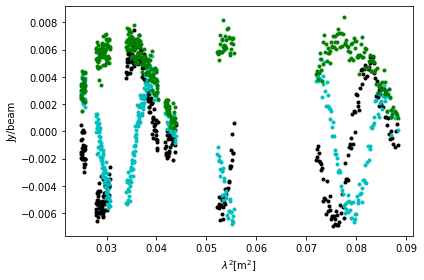

In [11]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [12]:
parameter = Parameter()

In [13]:
parameter.calculate_cellsize(dataset=measurements)

FWHM of the main peak of the RMTF: 54.613 rad/m^2
Maximum recovered width structure: 126.450 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 10895.205


In [14]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [15]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [16]:
F_dirty = dft.backward(measurements.data)

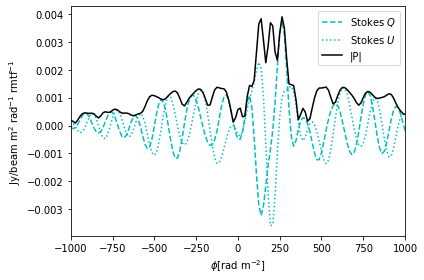

In [17]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [18]:
idx_noise = np.where(np.abs(parameter.phi)>8000)
noise_F = np.std(0.5*(F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
noise_F

4.4710312e-05

In [19]:
P_back = nufft.forward_normalized(F_dirty)

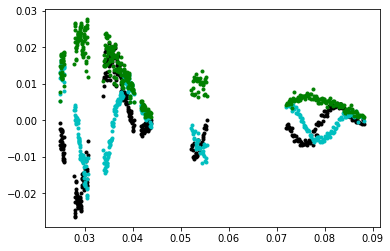

In [20]:
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [21]:
F_back = nufft.backward(measurements.data)

(-1000.0, 1000.0)

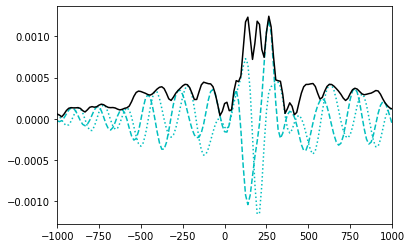

In [22]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000,1000])

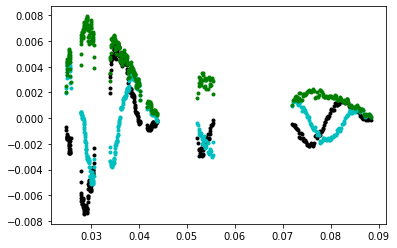

In [23]:
P_back = nufft.forward_normalized(F_back)
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [24]:
wav = Wavelet(wavelet_name="db4", mode="periodization")

In [25]:
lambda_l1 = np.sqrt(2 * len(measurements.data) + 4 * np.sqrt(len(measurements.data)))*noise_F
#lambda_l1 /= 10
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [26]:
len(F_back)

1568

In [27]:
len(parameter.data)

1568

In [28]:
parameter.data = F_dirty

In [29]:
parameter.complex_data_to_real()

In [30]:
wav.calculate_max_level(parameter.data)

8

In [31]:
parameter.data = wav.decompose(parameter.data)

In [32]:
parameter.n

3138

In [33]:
nufft.parameter.n

1568

In [34]:
parameter.n

3138

In [35]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 29
Iteration:  0  objective function value: 0.00362


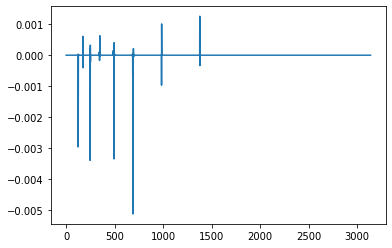

In [36]:
# Coefficients
plt.plot(X.data)

In [37]:
print(X.calculate_sparsity())

99.96813256851497


In [38]:
X.data = wav.reconstruct(X.data)

(-1000.0, 1000.0)

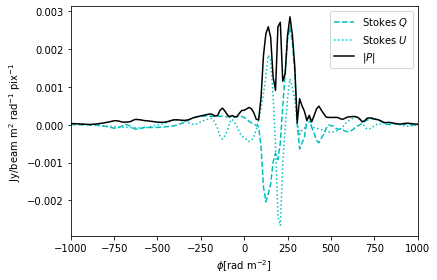

In [39]:
X.real_data_to_complex()

plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

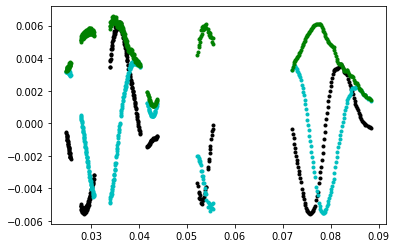

In [40]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
#plt.ylim([-0.007,0.008])

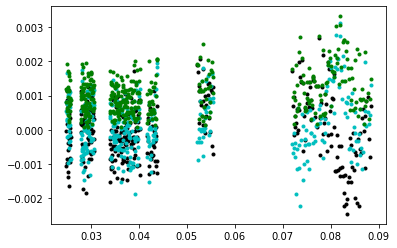

In [41]:
plt.plot(measurements.lambda2, measurements.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.residual), 'g.', label=r"$|P|$")

(-1000.0, 1000.0)

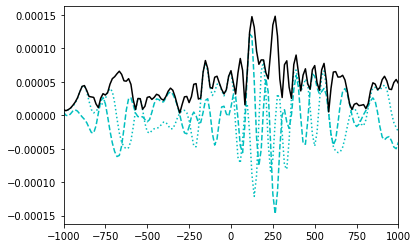

In [42]:
F_residual = nufft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [43]:
lags, autocorr_res, bound, percentage_real_in, percentage_imag_in = measurements.assess_residuals()

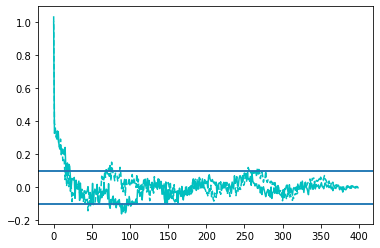

In [44]:
plt.plot(lags, autocorr_res.real, 'c-', label=r"Real part")
plt.plot(lags, autocorr_res.imag, 'c--', label=r"Imaginary part")
plt.axhline(-bound)
plt.axhline(bound)
plt.axhline(-bound)
plt.axhline(bound)
plt.grid()
plt.grid()

In [45]:
percentage_real_in, percentage_imag_in

(89.0, 91.5)

In [46]:
conv_model = X.convolve(normalized=True) + F_residual

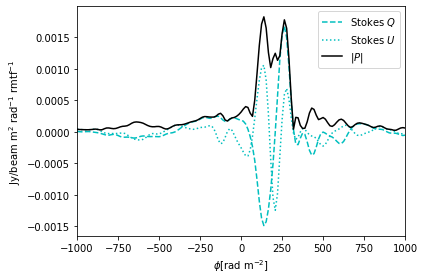

In [47]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("restored.png", dpi=100)

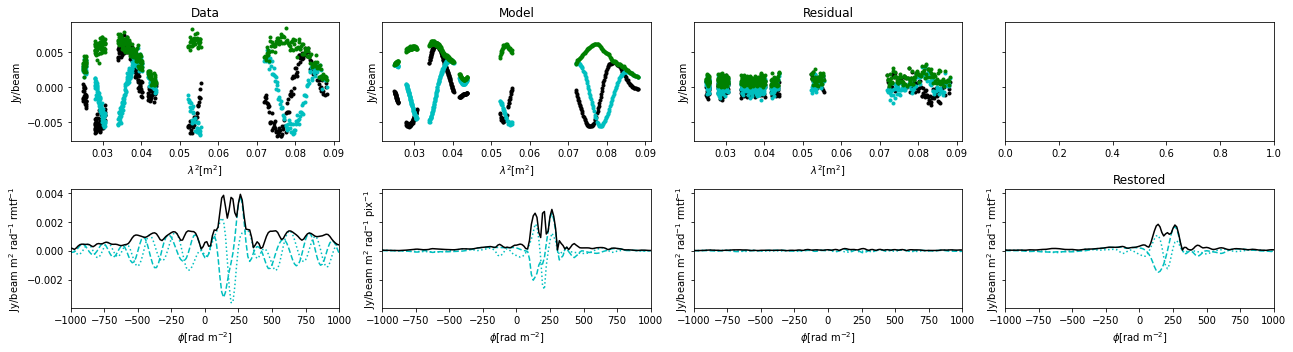

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))

# Data
ax[0,0].plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
ax[0,0].plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
ax[0,0].plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
ax[0,0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,0].set_ylabel(r'Jy/beam')
ax[0,0].title.set_text("Data")

ax[1,0].plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[1,0].plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[1,0].plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
ax[1,0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,0].set_xlim([-1000,1000])

# Model
ax[0,1].plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
ax[0,1].plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
ax[0,1].plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
ax[0,1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,1].set_ylabel(r'Jy/beam')
ax[0,1].title.set_text("Model")

ax[1,1].plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
ax[1,1].plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
ax[1,1].plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
ax[1,1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
ax[1,1].set_xlim([-1000,1000])

# Residual

# Model
ax[0,2].plot(measurements.lambda2, measurements.residual.real, 'k.', label=r"Stokes $Q$")
ax[0,2].plot(measurements.lambda2, measurements.residual.imag, 'c.', label=r"Stokes $U$")
ax[0,2].plot(measurements.lambda2, np.abs(measurements.residual), 'g.', label=r"$|P|$")
ax[0,2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,2].set_ylabel(r'Jy/beam')
ax[0,2].title.set_text("Residual")

ax[1,2].plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
ax[1,2].plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
ax[1,2].plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
ax[1,2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,2].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,2].set_xlim([-1000,1000])
fig.tight_layout()

ax[1,3].plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
ax[1,3].plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
ax[1,3].plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
ax[1,3].set_xlim([-1000,1000])
ax[1,3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,3].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,3].title.set_text("Restored")